<center>
# КОНКУРСНАЯ ЗАДАЧА ПРЕДСКАЗАНИЯ ОТКЛИКА ОТП БАНКА

## ЭТАП I. ПОСТРОЕНИЕ МОДЕЛИ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ - ЧАСТИ ИСТОРИЧЕСКОЙ ВЫБОРКИ И ЕЕ ПРОВЕРКА НА КОНТРОЛЬНОЙ ВЫБОРКЕ - ЧАСТИ ИСТОРИЧЕСКОЙ ВЫБОРКИ

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

## I.1. Считывание CSV-файла, содержащего исторические данные, в объект DataFrame

In [2]:
# увеличиваем количество выводимых столбцов
pd.set_option('display.max_columns', 60)
# загружаем набор данных
data = pd.read_csv('Credit_OTP.csv', encoding='cp1251', sep=';')
# выводим первые 10 наблюдений
data.head(10)

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000,6,8650,0,1,220,18.0,0,0,1,1,1,6,2,1,1580,1580,NaN
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650,6,4000,0,1,137,97.0,1,0,1,1,1,6,1,1,4020,4020,NaN
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126,12,4000,0,1,251,84.0,0,0,1,2,1,11,0,0,0,0,NaN
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,"8491,82",6,5000,0,0,36,168.0,1,1,1,1,1,6,3,1,"1589,923333",1590,NaN
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990,12,4000,0,1,83,101.0,1,0,1,2,1,16,2,1,"1152,15",2230,NaN
5,59911784,0,29,1,0,0,0,0,Среднее,Гражданский брак,Торговля,Специалист,Частная компания,Без участия,Адм-хоз. и трансп. службы,от 20000 до 50000 руб.,12000,Белгородская область,Белгородская область,Белгородская область,Белгородская область,ЦЕНТРАЛЬНЫЙ 1,1,1,1,1,1,0,1,0,0,0,0,0,30615,12,3500,0,0,108,40.0,1,0,1,2,1,11,0,0,0,0,NaN
6,59911832,0,35,1,0,0,1,1,Высшее,Разведен(а),Другие сферы,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,15000,Вологодская область,Вологодская область,Вологодская область,Вологодская область,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,1,0,0,0,0,0,0,10450,3,15000,0,1,48,6.0,0,0,1,2,2,14,0,0,0,0,NaN
7,59912034,0,41,1,0,1,0,0,Среднее,Состою в браке,Сельское хозяйство,Рабочий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,6000,Волгоградская область,Волгоградская область,Волгоградская область,Волгоградская область,ЮЖНЫЙ,1,1,1,1,1,1,0,0,0,0,0,0,15035,10,465,0,1,204,6.0,1,1,1,2,1,11,0,0,0,0,NaN
8,59912560,0,53,1,0,0,2,0,Высшее,Состою в браке,Здравоохранение,Руководитель высшего звена,Частная компания,Без участия,Участие в основ. деятельности,свыше 50000 руб.,100000,Ярославская область,Ярославская область,Ярославская область,Ярославская область,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,0,0,0,0,0,0,0,"32914,31",4,"29080,92",0,0,228,156.0,1,0,1,1,1,3,0,0,0,0,NaN
9,59912659,0,43,1,0,1,0,0,Среднее специальное,Состою в браке,Образование,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,700

## I.2. Преобразование типов переменных

In [3]:
# выводим информацию о количестве непропущенных 
# наблюдений в переменных и типах переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 52 columns):
AGREEMENT_RK                  15223 non-null int64
TARGET                        15223 non-null int64
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null int64
SOCSTATUS_PENS_FL             15223 non-null int64
GENDER                        15223 non-null int64
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  13856 non-null object
GEN_TITLE                     13856 non-null object
ORG_TP_STATE                  13856 non-null object
ORG_TP_FCAPITAL               13858 non-null object
JOB_DIR                       13856 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null object
REG_ADDRESS_PRO

In [4]:
# переменные, неверно записанные как количественные,
# преобразуем в тип object
object_columns = data.columns[data.columns.str.contains('FL|GENDER|AGREEMENT')]
data[object_columns] = data[object_columns].astype('object')

In [5]:
# в указанных переменных заменяем запятую на точку в качестве
# десятичного разделителя и преобразуем в тип float
for column in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 
               'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
    data[column] = data[column].str.replace(',', '.').astype('float')
    


In [6]:
# вновь смотрим типы переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 52 columns):
AGREEMENT_RK                  15223 non-null object
TARGET                        15223 non-null int64
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  13856 non-null object
GEN_TITLE                     13856 non-null object
ORG_TP_STATE                  13856 non-null object
ORG_TP_FCAPITAL               13858 non-null object
JOB_DIR                       13856 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRES

In [7]:
# проверяем, что запятые заменились на точки
data[['PERSONAL_INCOME','CREDIT', 'FST_PAYMENT', 'LOAN_AVG_DLQ_AMT','LOAN_MAX_DLQ_AMT']].head(10)

,PERSONAL_INCOME,CREDIT,FST_PAYMENT,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT
0,5000.0,8000.00,8650.00,1580.000000,1580.0
1,12000.0,21650.00,4000.00,4020.000000,4020.0
2,9000.0,33126.00,4000.00,0.000000,0.0
3,25000.0,8491.82,5000.00,1589.923333,1590.0
4,12000.0,21990.00,4000.00,1152.150000,2230.0
5,12000.0,30615.00,3500.00,0.000000,0.0
6,15000.0,10450.00,15000.00,0.000000,0.0
7,6000.0,15035.00,465.00,0.000000,0.0
8,100000.0,32914.31,29080.92,0.000000,0.0
9,7000.0,4440.00,540.00,0.000000,0.0


## I.3. Импутация пропусков, не использующая результаты математических вычислений (импутация, которую можно выполнять до/после разбиения на обучение/контроль)

In [8]:
# если в интересующей нас переменной есть пропуск 
# или при этом переменная SOCSTATUS_PENS_FL имеет значение 1,
# заменяем такие пропуски меткой "Не указано"
data['GEN_INDUSTRY'] = np.where(data['GEN_INDUSTRY'].isnull() | (data['SOCSTATUS_PENS_FL'] == 1), 'Не указано', \
                                data['GEN_INDUSTRY'])

data['GEN_TITLE'] = np.where(data['GEN_TITLE'].isnull() | (data['SOCSTATUS_PENS_FL'] == 1), 'Не указано', \
                             data['GEN_TITLE'])

data['ORG_TP_STATE'] = np.where(data['ORG_TP_STATE'].isnull() | (data['SOCSTATUS_PENS_FL'] == 1), 'Не указано', \
                                data['ORG_TP_STATE'])
data['ORG_TP_FCAPITAL'] = np.where(data['ORG_TP_FCAPITAL'].isnull() | (data['SOCSTATUS_PENS_FL'] == 1), 'Не указано', \
                                   data['ORG_TP_FCAPITAL'])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 52 columns):
AGREEMENT_RK                  15223 non-null object
TARGET                        15223 non-null int64
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       13856 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRES

In [9]:
# заменяем пропуски в указанных переменных
# меткой "Не указано"
data['JOB_DIR'] = np.where(data['JOB_DIR'].isnull(), 'Не указано', data['JOB_DIR'])
data['REGION_NM'] = np.where(data['REGION_NM'].isnull(), 'Не указано', data['REGION_NM'])

# пропуски в переменной TP_PROVINCE заменим значением
# переменной FACT_ADDRESS_PROVINCE
data['TP_PROVINCE'] = np.where(data['TP_PROVINCE'].isnull(), 
                               data['FACT_ADDRESS_PROVINCE'], data['TP_PROVINCE'])
    
# заменяем пропуски в переменной 
# PREVIOUS_CARD_NUM_UTILIZED нулями
data['PREVIOUS_CARD_NUM_UTILIZED'] = np.where(data['PREVIOUS_CARD_NUM_UTILIZED'].isnull(), 0, 
                                              data['PREVIOUS_CARD_NUM_UTILIZED'])
# смотрим количество пропусков
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 52 columns):
AGREEMENT_RK                  15223 non-null object
TARGET                        15223 non-null int64
AGE                           15223 non-null int64
SOCSTATUS_WORK_FL             15223 non-null object
SOCSTATUS_PENS_FL             15223 non-null object
GENDER                        15223 non-null object
CHILD_TOTAL                   15223 non-null int64
DEPENDANTS                    15223 non-null int64
EDUCATION                     15223 non-null object
MARITAL_STATUS                15223 non-null object
GEN_INDUSTRY                  15223 non-null object
GEN_TITLE                     15223 non-null object
ORG_TP_STATE                  15223 non-null object
ORG_TP_FCAPITAL               15223 non-null object
JOB_DIR                       15223 non-null object
FAMILY_INCOME                 15223 non-null object
PERSONAL_INCOME               15223 non-null float64
REG_ADDRES

In [10]:
data.head(10)

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,OWN_AUTO,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,CREDIT,TERM,FST_PAYMENT,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_LIVING_TERM,WORK_TIME,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000.0,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,1,1,1,1,1,0,0,0,0,0,0,0,8000.00,6,8650.00,0,1,220,18.0,0,0,1,1,1,6,2,1,1580.000000,1580.0,0.0
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000.0,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,0,0,0,0,21650.00,6,4000.00,0,1,137,97.0,1,0,1,1,1,6,1,1,4020.000000,4020.0,0.0
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000.0,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,1,1,1,1,1,0,0,0,1,0,0,0,33126.00,12,4000.00,0,1,251,84.0,0,0,1,2,1,11,0,0,0.000000,0.0,0.0
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000.0,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,0,1,0,0,1,1,0,0,0,0,0,0,8491.82,6,5000.00,0,0,36,168.0,1,1,1,1,1,6,3,1,1589.923333,1590.0,0.0
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000.0,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,1,1,1,1,0,0,0,0,1,0,0,0,21990.00,12,4000.00,0,1,83,101.0,1,0,1,2,1,16,2,1,1152.150000,2230.0,0.0
5,59911784,0,29,1,0,0,0,0,Среднее,Гражданский брак,Торговля,Специалист,Частная компания,Без участия,Адм-хоз. и трансп. службы,от 20000 до 50000 руб.,12000.0,Белгородская область,Белгородская область,Белгородская область,Белгородская область,ЦЕНТРАЛЬНЫЙ 1,1,1,1,1,1,0,1,0,0,0,0,0,30615.00,12,3500.00,0,0,108,40.0,1,0,1,2,1,11,0,0,0.000000,0.0,0.0
6,59911832,0,35,1,0,0,1,1,Высшее,Разведен(а),Другие сферы,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,15000.0,Вологодская область,Вологодская область,Вологодская область,Вологодская область,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,1,0,0,0,0,0,0,10450.00,3,15000.00,0,1,48,6.0,0,0,1,2,2,14,0,0,0.000000,0.0,0.0
7,59912034,0,41,1,0,1,0,0,Среднее,Состою в браке,Сельское хозяйство,Рабочий,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,6000.0,Волгоградская область,Волгоградская область,Волгоградская область,Волгоградская область,ЮЖНЫЙ,1,1,1,1,1,1,0,0,0,0,0,0,15035.00,10,465.00,0,1,204,6.0,1,1,1,2,1,11,0,0,0.000000,0.0,0.0
8,59912560,0,53,1,0,0,2,0,Высшее,Состою в браке,Здравоохранение,Руководитель высшего звена,Частная компания,Без участия,Участие в основ. деятельности,свыше 50000 руб.,100000.0,Ярославская область,Ярославская область,Ярославская область,Ярославская область,ЦЕНТРАЛЬНЫЙ 2,1,1,1,1,1,0,0,0,0,0,0,0,32914.31,4,29080.92,0,0,228,156.0,1,0,1,1,1,3,0,0,0.000000,0.0,0.0
9,59912659,0,43,1,0,1,0,0,Среднее специальное,Состою в бр

## I.4. Обработка редких категорий

In [11]:
# выводим статистики по категориальным переменным,
# смотрим unique - количество уникальных значений,
# выявляем бесполезные переменные - переменные, у
# которых уникальных значений столько, сколько
# наблюдений (AGREEMENT_RK), и переменные с одним
# уникальным значением (DL_DOCUMENT_FL)
data.select_dtypes(include='object').describe()


,AGREEMENT_RK,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,DL_DOCUMENT_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,15223,2,2,2,7,5,32,13,6,3,11,5,81,81,80,72,12,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2
top,64585727,1,0,1,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,Краснодарский край,Краснодарский край,Краснодарский край,Краснодарский край,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1
freq,1,13847,13176,9964,6518,9416,2303,6680,6267,13009,11452,7077,674,674,674,790,2179,12765,14480,13493,12758,13782,10507,14097,11940,15074,14930,14558,15223,8961,9311,14389,13855


In [12]:
# удаляем идентификационную переменную AGREEMENT_RK,
# потому что у нее количество уникальных значений
# равно количеству наблюдений, переменную DL_DOCUMENT_FL, 
# потому что у нее одно уникальное значение
data.drop(['AGREEMENT_RK', 'DL_DOCUMENT_FL'], axis=1, inplace=True)
data.select_dtypes(include='object').describe()

,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,REG_FACT_FL,FACT_POST_FL,REG_POST_FL,REG_FACT_POST_FL,REG_FACT_POST_TP_FL,FL_PRESENCE_FL,AUTO_RUS_FL,HS_PRESENCE_FL,COT_PRESENCE_FL,GAR_PRESENCE_FL,LAND_PRESENCE_FL,GPF_DOCUMENT_FL,FACT_PHONE_FL,REG_PHONE_FL,GEN_PHONE_FL
count,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223,15223
unique,2,2,2,7,5,32,13,6,3,11,5,81,81,80,72,12,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,1,0,1,Среднее специальное,Состою в браке,Торговля,Специалист,Частная компания,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,Краснодарский край,Краснодарский край,Краснодарский край,Краснодарский край,ЮЖНЫЙ,1,1,1,1,1,0,0,0,0,0,0,1,1,0,1
freq,13847,13176,9964,6518,9416,2303,6680,6267,13009,11452,7077,674,674,674,790,2179,12765,14480,13493,12758,13782,10507,14097,11940,15074,14930,14558,8961,9311,14389,13855


In [13]:
# заново выделим подмножество категориальных переменных
# и пробежим по нему, выводя частоты категорий
# по каждой категориальной переменной, чтобы
# выявить редкие категории
for column in data.select_dtypes(include='object').columns:
    print(data[column].value_counts(dropna=False))

1    13847
0     1376
Name: SOCSTATUS_WORK_FL, dtype: int64
0    13176
1     2047
Name: SOCSTATUS_PENS_FL, dtype: int64
1    9964
0    5259
Name: GENDER, dtype: int64
Среднее специальное               6518
Среднее                           4679
Высшее                            3133
Неоконченное высшее                532
Неполное среднее                   340
Два и более высших образования      20
Ученая степень                       1
Name: EDUCATION, dtype: int64
Состою в браке        9416
Не состоял в браке    3622
Разведен(а)           1245
Вдовец/Вдова           588
Гражданский брак       352
Name: MARITAL_STATUS, dtype: int64
Торговля                                     2303
Не указано                                   2048
Другие сферы                                 1639
Металлургия/Промышленность/Машиностроение    1285
Государственная служба                       1223
Здравоохранение                              1087
Образование                                   923
Транспорт 

Name: GPF_DOCUMENT_FL, dtype: int64
1    9311
0    5912
Name: FACT_PHONE_FL, dtype: int64
0    14389
1      834
Name: REG_PHONE_FL, dtype: int64
1    13855
0     1368
Name: GEN_PHONE_FL, dtype: int64


In [14]:
# заменяем категорию "Не указано" на категорию "ЮЖНЫЙ"
data['REGION_NM'] = np.where(data['REGION_NM'] == 'Не указано', 'ЮЖНЫЙ', data['REGION_NM'])
    
# заменяем неверную категорию "ПОВОЛЖСКИЙ" на категорию "ПРИВОЛЖСКИЙ"
data.at[data['REGION_NM'] == 'ПОВОЛЖСКИЙ', 'REGION_NM'] = 'ПРИВОЛЖСКИЙ'

# заменяем Москва на Московский регион
data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Москва', 'POSTAL_ADDRESS_PROVINCE'] = 'Московская область'
    
# записываем редкие категории в одну отдельную категорию
for i in ['REG_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE']:
    data[i] = np.where(#(data[i] == 'Москва') | 
                        (data[i] == 'Хакасия')
                       | (data[i] == 'Ямало-Ненецкий АО')
                       | (data[i] == 'Магаданская область')
                       | (data[i] == 'Калмыкия')
                       | (data[i] == 'Дагестан')
                       | (data[i] == 'Агинский Бурятский АО')
                       | (data[i] == 'Усть-Ордынский Бурятский АО')
                       | (data[i] == 'Эвенкийский АО')
                       | (data[i] == 'Коми-Пермяцкий АО')
                       | (data[i] == 'Чечня'), 
                       'ДРУГОЕ', data[i])

data['TP_PROVINCE'] = np.where((data['TP_PROVINCE'] == 'Сахалинская область')
                               | (data['TP_PROVINCE'] == 'Еврейская АО')
                               | (data['TP_PROVINCE'] == 'Магаданская область')
                               | (data['TP_PROVINCE'] == 'Дагестан')
                               | (data['TP_PROVINCE'] == 'Кабардино-Балкария'), 
                               'ДРУГОЕ', data['TP_PROVINCE'])

In [15]:
# укрупняем категории переменной EDUCATION
data.loc[data['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
data.loc[data['EDUCATION'] == 'Два и более высших образования', 'EDUCATION'] = 'Высшее'

# смотрим частоты категорий переменной EDUCATION
data['EDUCATION'].value_counts(dropna=False)

Среднее специальное    6518
Среднее                4679
Высшее                 3154
Неоконченное высшее     532
Неполное среднее        340
Name: EDUCATION, dtype: int64

In [16]:
# записываем некоторые категории переменной GEN_INDUSTRY 
# в отдельную категорию
data.loc[data['GEN_INDUSTRY'] == 'СМИ/Реклама/PR-агенства', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Юридические услуги/нотариальные услуги', 
        'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Страхование', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Туризм', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Недвижимость', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Управляющая компания', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Логистика', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Подбор персонала', 'GEN_INDUSTRY'] = 'Другие сферы'
data.loc[data['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'Другие сферы'

# смотрим частоты категорий переменной GEN_INDUSTRY
data['GEN_INDUSTRY'].value_counts(dropna=False)

Торговля                                     2303
Не указано                                   2048
Другие сферы                                 1825
Металлургия/Промышленность/Машиностроение    1285
Государственная служба                       1223
Здравоохранение                              1087
Образование                                   923
Транспорт                                     763
Сельское хозяйство                            670
Строительство                                 556
Коммунальное хоз-во/Дорожные службы           495
Ресторанный бизнес/Общественное питание       393
Наука                                         361
Нефтегазовая промышленность                   220
Банк/Финансы                                  168
Сборочные производства                        167
Энергетика                                    139
Развлечения/Искусство                         129
ЧОП/Детективная д-ть                          128
Информационные услуги                         102


In [17]:
# укрупняем категории переменной GEN_TITLE
data.loc[data['GEN_TITLE'] == 'Партнер', 'GEN_TITLE'] = 'Другое'
data.loc[data['GEN_TITLE'] == 'Военнослужащий по контракту', 'GEN_TITLE'] = 'Другое'

# смотрим частоты категорий переменной GEN_TITLE
data['GEN_TITLE'].value_counts(dropna=False)

Специалист                        6680
Рабочий                           2898
Не указано                        2048
Служащий                           858
Руководитель среднего звена        657
Работник сферы услуг               529
Высококвалифиц. специалист         529
Руководитель высшего звена         409
Другое                             272
Индивидуальный предприниматель     210
Руководитель низшего звена         133
Name: GEN_TITLE, dtype: int64

In [18]:
# укрупняем категории переменной ORG_TP_STATE
data.loc[data['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 
         'ORG_TP_STATE'] = 'Частная компания'

# смотрим частоты категорий переменной ORG_TP_STATE
data['ORG_TP_STATE'].value_counts(dropna=False)

Частная компания                  6288
Государственная комп./учреж.      5726
Не указано                        2048
Индивидуальный предприниматель     930
Некоммерческая организация         231
Name: ORG_TP_STATE, dtype: int64

In [19]:
# укрупняем категории переменной JOB_DIR
data.loc[data['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Другое'
data.loc[data['JOB_DIR'] == 'Кадровая служба и секретариат', 'JOB_DIR'] = 'Другое'
data.loc[data['JOB_DIR'] == 'Пр-техн. обесп. и телеком.', 'JOB_DIR'] = 'Другое'
data.loc[data['JOB_DIR'] == 'Юридическая служба', 'JOB_DIR'] = 'Другое'

# смотрим частоты категорий переменной JOB_DIR
data['JOB_DIR'].value_counts(dropna=False)

Участие в основ. деятельности    11452
Не указано                        1367
Вспомогательный техперсонал       1025
Бухгалтерия, финансы, планир.      481
Адм-хоз. и трансп. службы          279
Другое                             238
Снабжение и сбыт                   217
Служба безопасности                164
Name: JOB_DIR, dtype: int64

In [20]:
# Переносим из OWN_AUTO значение 2 в 1
data['OWN_AUTO'] = np.where(data['OWN_AUTO'] == 2, 1, data['OWN_AUTO'])

In [21]:
for column in data.select_dtypes(include='int64').columns:
    print(data[column].value_counts(dropna=False))

0    13411
1     1812
Name: TARGET, dtype: int64
27    485
26    480
33    461
31    461
30    460
34    455
35    442
24    437
32    435
25    430
38    429
29    427
37    420
39    415
28    414
40    406
23    380
36    376
42    373
41    363
44    363
48    358
45    358
50    352
52    349
51    349
49    348
53    339
43    335
56    334
47    320
46    313
54    295
22    292
55    289
57    283
58    276
59    216
61    212
60    206
62    148
63    138
64    127
65     43
66     17
21     13
67      1
Name: AGE, dtype: int64
1     5087
0     4984
2     4140
3      799
4      133
5       59
6       12
7        5
10       3
8        1
Name: CHILD_TOTAL, dtype: int64
0    8226
1    4535
2    2167
3     243
4      42
5       5
6       4
7       1
Name: DEPENDANTS, dtype: int64
0    13453
1     1770
Name: OWN_AUTO, dtype: int64
6     5063
12    2951
10    2473
3     1919
5      626
9      542
4      446
8      401
18     263
24     166
7      143
11      63
36      50
15      49

## I.5. Конструирование новых признаков, не использующее результаты математических вычислений (которое можно выполнять до/после разбиения на обучение/контроль)

In [22]:
# создаем переменную FACT_TP_FL, которая принимает значение 1, если 
# область фактического пребывания клиента и область торговой точки, 
# где клиент брал последний кредит, совпадают, или 0
# в противном случае
data['FACT_TP_FL'] = np.where(data['FACT_ADDRESS_PROVINCE'] == data['TP_PROVINCE'], 
                              1, 0).astype('object')


In [23]:
data['FACT_TP_FL'].value_counts(dropna=False)

1    14033
0     1190
Name: FACT_TP_FL, dtype: int64

In [24]:
# отключаем на всякий случай экспоненциальное представление
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# выводим статистики по количественным переменным
data.describe()

,TARGET,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,13855.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000
mean,0.119,40.406,1.099,0.645,13853.836,0.116,14667.959,8.101,3398.563,3039.340,292.212,1.388,0.752,7.876,0.195,0.130,239.457,243.022,0.019
std,0.324,11.601,0.995,0.812,9015.468,0.321,12147.873,4.094,5158.109,262455.437,24364.832,0.794,0.988,7.956,0.685,0.356,827.700,836.100,0.138
min,0.000,21.000,0.000,0.000,24.000,0.000,2000.000,3.000,0.000,-26.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,30.000,0.000,0.000,8000.000,0.000,6500.000,6.000,1000.000,41.000,24.000,1.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,39.000,1.000,0.000,12000.000,0.000,11550.000,6.000,2000.000,108.000,48.000,1.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,50.000,2.000,1.000,17000.000,0.000,19170.000,10.000,4000.000,204.000,110.000,2.000,1.000,8.000,0.000,0.000,0.000,0.000,0.000
max,1.000,67.000,10.000,7.000,250000.000,1.000,119700.000,36.000,140000.000,28101997.000,2867959.000,11.000,11.000,114.000,13.000,8.000,28012.200,28012.200,2.000


##### Обращаем внимание на:
- отрицательное минимальное значение `FACT_LIVING_TERM`;
- на нулевые минимальные значения переменных `CHILD_TOTAL`, `DEPENDANTS`, `OWN_AUTO`, `FST_PAYMENT`, `LOAN_NUM_CLOSED`, `LOAN_DLQ_NUM`, `LOAN_MAX_DLQ`, `LOAN_AVG_DLQ_AMT`, `LOAN_MAX_DLQ_AMT`, `PREVIOUS_CARD_NUM_UTILIZED`, при конструировании новых признаков на базе таких переменных нужно быть особо внимательным, т.к. при делении на ноль могут появятся бесконечные значения (infinite values);
- отмечаем аномально большие максимальные значения переменных `FACT_LIVING_TERM` и `WORK_TIME`, такие значения могут снизить качество регрессионной модели

In [25]:
# значения переменной FACT_LIVING_TERM берем по модулю, 
# чтобы избавиться от отрицательных значений
data['FACT_LIVING_TERM'] = data['FACT_LIVING_TERM'].abs()
data.describe()

,TARGET,AGE,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,OWN_AUTO,CREDIT,TERM,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_NUM_PAYM,LOAN_DLQ_NUM,LOAN_MAX_DLQ,LOAN_AVG_DLQ_AMT,LOAN_MAX_DLQ_AMT,PREVIOUS_CARD_NUM_UTILIZED
count,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,13855.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000,15223.000
mean,0.119,40.406,1.099,0.645,13853.836,0.116,14667.959,8.101,3398.563,3039.343,292.212,1.388,0.752,7.876,0.195,0.130,239.457,243.022,0.019
std,0.324,11.601,0.995,0.812,9015.468,0.321,12147.873,4.094,5158.109,262455.437,24364.832,0.794,0.988,7.956,0.685,0.356,827.700,836.100,0.138
min,0.000,21.000,0.000,0.000,24.000,0.000,2000.000,3.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,30.000,0.000,0.000,8000.000,0.000,6500.000,6.000,1000.000,41.000,24.000,1.000,0.000,4.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,39.000,1.000,0.000,12000.000,0.000,11550.000,6.000,2000.000,108.000,48.000,1.000,0.000,5.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,50.000,2.000,1.000,17000.000,0.000,19170.000,10.000,4000.000,204.000,110.000,2.000,1.000,8.000,0.000,0.000,0.000,0.000,0.000
max,1.000,67.000,10.000,7.000,250000.000,1.000,119700.000,36.000,140000.000,28101997.000,2867959.000,11.000,11.000,114.000,13.000,8.000,28012.200,28012.200,2.000


In [26]:
data[['FACT_LIVING_TERM', 'WORK_TIME']]

,FACT_LIVING_TERM,WORK_TIME
0,220,18.000
1,137,97.000
2,251,84.000
3,36,168.000
4,83,101.000
5,108,40.000
6,48,6.000
7,204,6.000
8,228,156.000
9,279,72.000


## I.6. Разбиение на обучающую и контрольную выборки

In [27]:
# создаем обучающий массив признаков, обучающий массив меток,
# тестовый массив признаков, тестовый массив меток
train, test, y_train, y_test = train_test_split(data.drop('TARGET', axis=1), 
                                                data['TARGET'], 
                                                test_size=.3, 
                                                stratify=data['TARGET'], 
                                                random_state=100)

## I.7. Импутация пропусков, использующая статистики - результаты математических вычислений (ее нужно выполнять после разбиения на обучение/контроль)

In [28]:
# наблюдения, в которых количество лет проживания 
# по месту фактического пребывания превышает
# возраст, записываем как пропуски 
train['FACT_LIVING_TERM'] = np.where(train['FACT_LIVING_TERM'] / 12 > train['AGE'], np.NaN, train['FACT_LIVING_TERM'])
test['FACT_LIVING_TERM'] = np.where(test['FACT_LIVING_TERM'] / 12 > test['AGE'], np.NaN, test['FACT_LIVING_TERM'])

# импутируем пропуски медианой, вычисленной 
# на обучающей выборке
train['FACT_LIVING_TERM'].fillna(train['FACT_LIVING_TERM'].median(), inplace=True)
test['FACT_LIVING_TERM'].fillna(train['FACT_LIVING_TERM'].median(), inplace=True)

In [29]:
# наблюдения, в которых время работы в годах превышает 
# возраст (например, человек работает 40 лет, а живет 
# всего 25), записываем как пропуски 
train['WORK_TIME'] = np.where(train['WORK_TIME'] / 12 > train['AGE'], np.NaN, train['WORK_TIME'])
test['WORK_TIME'] = np.where(test['WORK_TIME'] / 12 > test['AGE'], np.NaN, test['WORK_TIME'])

# наблюдения, в которых разница между возрастом и временем работы в годах 
# меньше 16 (например, у 30-летнего время работы в годах составляет 20 лет,
# получается, он работает с 10 лет), записываем как пропуски 

train['WORK_TIME'] = np.where((train['AGE'] - train['WORK_TIME'] / 12) < 16, np.NaN, train['WORK_TIME'])
test['WORK_TIME'] = np.where((test['AGE'] - test['WORK_TIME'] / 12) < 16, np.NaN, test['WORK_TIME'])

# импутируем пропуски медианой, вычисленной 
# на обучающей выборке
train['WORK_TIME'].fillna(train['WORK_TIME'].median(), inplace=True)
test['WORK_TIME'].fillna(train['WORK_TIME'].median(), inplace=True)

In [30]:
# выводим информацию об общем количестве пропущенных 
# наблюдений в обучающей и контрольной выборках
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


In [31]:
def importance_auc(train, target, test):
    train_copy = train.loc[:, train.apply(pd.Series.nunique) > 20].copy()
    test_copy = test.loc[:, test.apply(pd.Series.nunique) > 20].copy()
    # создаем список переменных
    col_list = train_copy.select_dtypes(include=['number']).columns
    # создаем список, в который будем записывать auc
    auc_list = []
    for i in col_list:
        train_copy[i].fillna(train_copy[i].median(), inplace=True)
        power = PowerTransformer(
            method='yeo-johnson', standardize=True).fit(train_copy[i].values.reshape(-1,1))
        train_copy[i] = power.transform(train_copy[i].values.reshape(-1,1))
        test_copy[i].fillna(test_copy[i].median(), inplace=True)
        test_copy[i] = power.transform(test_copy[i].values.reshape(-1,1))
        logreg = LogisticRegression(solver='liblinear').fit(train_copy[i].values.reshape(-1,1), y_train)
        auc = roc_auc_score(y_test, logreg.predict_proba(test_copy[i].values.reshape(-1,1))[:, 1])
        auc_list.append(auc)
    
    result = pd.DataFrame({'Переменная': col_list,
                           'AUC': auc_list})
    result = np.round(result.sort_values(by='AUC', ascending=False), 3)
    cm = sns.light_palette('yellow', as_cmap=True)
    return(result.style.background_gradient(cmap=cm))

In [32]:
importance_auc(train, y_train, test)

,Переменная,AUC
0,AGE,0.592
1,PERSONAL_INCOME,0.584
5,WORK_TIME,0.567
4,FACT_LIVING_TERM,0.559
8,LOAN_MAX_DLQ_AMT,0.545
7,LOAN_AVG_DLQ_AMT,0.545
3,FST_PAYMENT,0.539
2,CREDIT,0.525
6,LOAN_NUM_PAYM,0.51


## I.8. Поиск преобразований переменных, максимизирующих нормальность распределения (дается в сокращенном виде)

In [33]:
def diagnostics_skewness(df, target):
    # создаем список переменных
    col_list = df.select_dtypes(include=['number']).columns
    skew_initial_list = []
    skew_pos_reciprocal_list = []
    skew_neg_reciprocal_list = []
    skew_log_list = []
    skew_corr_log_001_list = []
    skew_corr_log_01_list = []
    skew_corr_log_1_list = []
    skew_corr_log_5_list = []
    skew_cbrt_list = []
    skew_sqrt_list = []
    
    
    # запускаем цикл, который вычисляет скос по каждой 
    # преобразованной переменной
    for i in col_list:
        a = 0.001
        skew_initial = df[i].skew()
        skew_pos_reciprocal = (1 / (df[i].clip(0) + a)).skew()
        skew_neg_reciprocal = (-1 / (df[i].clip(0) + a)).skew()
        skew_log = np.log(df[i].clip(0) + a).skew()
        skew_corr_log_001 = np.log((df[i].clip(0) / df[i].mean()) + 0.001).skew()
        skew_corr_log_01 = np.log((df[i].clip(0) / df[i].mean()) + 0.01).skew()
        skew_corr_log_1 = np.log((df[i].clip(0) / df[i].mean()) + 0.1).skew()
        skew_corr_log_5 = np.log((df[i].clip(0) / df[i].mean()) + 0.5).skew()
        skew_cbrt = np.cbrt(df[i]).skew()
        skew_sqrt = np.sqrt(df[i]).skew()
        skew_initial_list.append(skew_initial)
        skew_pos_reciprocal_list.append(skew_pos_reciprocal)
        skew_neg_reciprocal_list.append(skew_neg_reciprocal)
        skew_log_list.append(skew_log)
        skew_corr_log_001_list.append(skew_corr_log_001)
        skew_corr_log_01_list.append(skew_corr_log_01)
        skew_corr_log_1_list.append(skew_corr_log_1)
        skew_corr_log_5_list.append(skew_corr_log_5)
        skew_cbrt_list.append(skew_cbrt)
        skew_sqrt_list.append(skew_sqrt)   

    result = pd.DataFrame({'Переменная': col_list,
                           'Skew_init': skew_initial_list,
                           'Skew_pos_recip': skew_pos_reciprocal_list,
                           'Skew_neg_recip': skew_neg_reciprocal_list,
                           'Skew_log': skew_log_list,
                           'Skew_adj_log (k=0.001)': skew_corr_log_001_list,
                           'Skew_adj_log (k=0.01)': skew_corr_log_01_list,
                           'Skew_adj_log (k=0.1)': skew_corr_log_1_list,
                           'Skew_adj_log (k=0.5)': skew_corr_log_5_list,
                           'Skew_cbrt': skew_cbrt_list,
                           'Skew_sqrt': skew_sqrt_list})
    result = np.round(result.sort_values(by='Skew_init', ascending=False), 3)
    cm = sns.light_palette('magenta', as_cmap=True)
    return(result.style.background_gradient(cmap=cm))

In [34]:
diagnostics_skewness(train, y_train)

,Переменная,Skew_init,Skew_pos_recip,Skew_neg_recip,Skew_log,Skew_adj_log (k=0.001),Skew_adj_log (k=0.01),Skew_adj_log (k=0.1),Skew_adj_log (k=0.5),Skew_cbrt,Skew_sqrt
17,PREVIOUS_CARD_NUM_UTILIZED,7.211,-7.037,7.037,7.039,7.038,7.038,7.039,7.04,7.046,7.061
13,LOAN_DLQ_NUM,7,-2.269,2.269,2.297,2.287,2.302,2.349,2.459,2.515,2.979
7,FST_PAYMENT,6.744,3.195,-3.195,-2.899,-2.022,-1.195,0.046,1.014,0.186,1.6
15,LOAN_AVG_DLQ_AMT,5.856,-2.269,2.269,2.283,2.301,2.325,2.388,2.511,2.519,2.857
16,LOAN_MAX_DLQ_AMT,5.771,-2.269,2.269,2.282,2.301,2.324,2.387,2.507,2.515,2.845
3,PERSONAL_INCOME,5.024,101.043,-101.043,0.13,0.164,0.253,0.437,0.835,0.941,1.428
14,LOAN_MAX_DLQ,3.495,-2.269,2.269,2.271,2.271,2.272,2.275,2.282,2.289,2.337
12,LOAN_NUM_PAYM,3.176,2.896,-2.896,0.58,0.584,0.62,0.877,1.343,1.373,1.754
5,CREDIT,2.836,1.518,-1.518,0.067,0.07,0.091,0.265,0.701,0.737,1.152
10,LOAN_NUM_TOTAL,2.753,-1.257,1.257,1.612,1.612,1.615,1.65,1.778,1.856,2.019


In [35]:
#важные переменные AGE, PERSONAL_INCOME, WORK_TIME, FACT_LIVING_TERM

Скос 1.0181444392860792
Эксцесс 0.9035560079843634


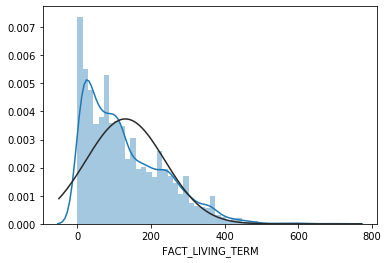

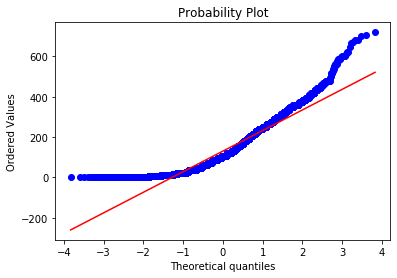

In [36]:
# строим гистограмму распределения и график
# квантиль-квантиль для переменной FACT_LIVING_TERM
sns.distplot(train['FACT_LIVING_TERM'], fit=norm)
fig = plt.figure()
res = stats.probplot(train['FACT_LIVING_TERM'], plot=plt)
print("Скос", train['FACT_LIVING_TERM'].skew())
print("Эксцесс", train['FACT_LIVING_TERM'].kurtosis())

Скос 29.75263977000883
Эксцесс 883.3956456110304


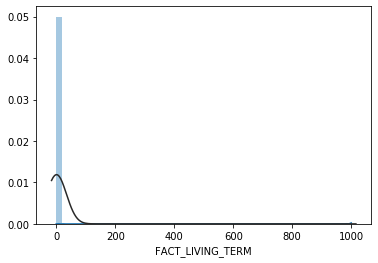

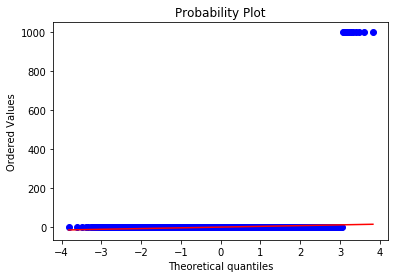

In [37]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив обратное 
# преобразование для переменной FACT_LIVING_TERM,
# используем метод .clip() и константу a, чтобы не брать
# логарифм отрицательных чисел и нуля
a = 0.001
sns.distplot(np.reciprocal(
    train['FACT_LIVING_TERM'] + a), fit=norm)
fig = plt.figure()
res = stats.probplot(np.reciprocal(
    train['FACT_LIVING_TERM'] + a), plot=plt)
var = np.reciprocal(train['FACT_LIVING_TERM'] + a)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос -1.7640436097052787
Эксцесс 7.611074431790174


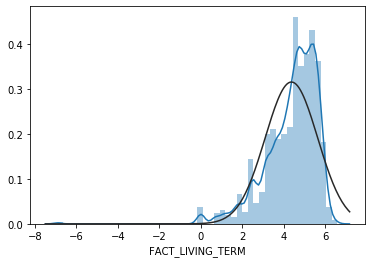

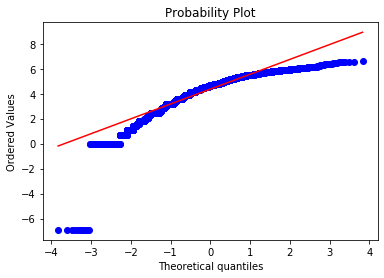

In [38]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив логарифмическое 
# преобразование для переменной FACT_LIVING_TERM,
# используем метод .clip() и константу a, чтобы не брать
# логарифм отрицательных чисел и нуля
sns.distplot(np.log(
    train['FACT_LIVING_TERM'] + a), fit=norm)
fig = plt.figure()
res = stats.probplot(np.log(
    train['FACT_LIVING_TERM'] + a), plot=plt)
var = np.log(train['FACT_LIVING_TERM'] + a)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос -1.2110164684857303
Эксцесс 1.7555050924872138


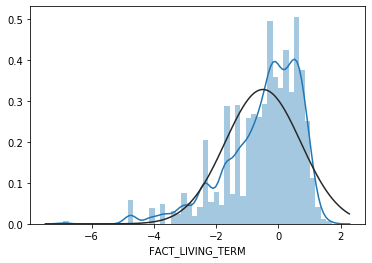

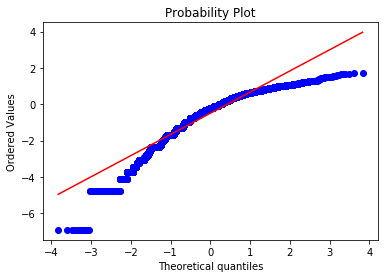

In [39]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив логарифмическое 
# преобразование по формуле log(x/mean(x)+k)
# для переменной FACT_LIVING_TERM,
# где k - небольшое значение, близкое к 0,
# чтобы сильнее смещать распределение влево
k = 0.001
sns.distplot(
    np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k), fit=norm)
fig = plt.figure()
res = stats.probplot(
    np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k), plot=plt)
var = np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос 0.06254428216483568
Эксцесс -0.9792864628257969


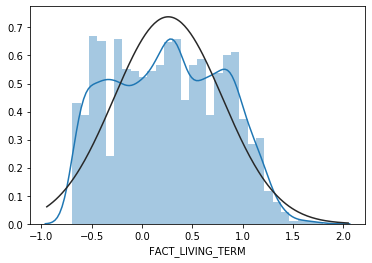

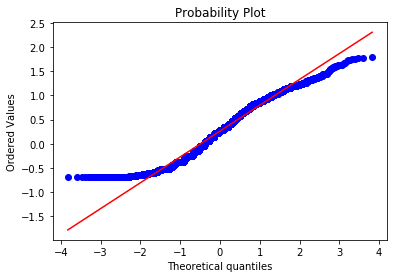

In [40]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив логарифмическое 
# преобразование по формуле log(x/mean(x)+k)
# для переменной FACT_LIVING_TERM,
# где k - небольшое значение, близкое к 1,
# чтобы слабее смещать распределение влево
k = 0.5
sns.distplot(
    np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k), 
    fit=norm)
fig = plt.figure()
res = stats.probplot(
    np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k), 
    plot=plt)
var = np.log((train['FACT_LIVING_TERM'] / train['FACT_LIVING_TERM'].mean()) + k)
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос -0.4419381477873673
Эксцесс -0.30500979706137255


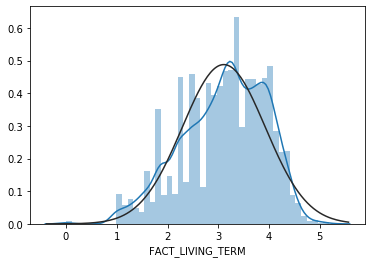

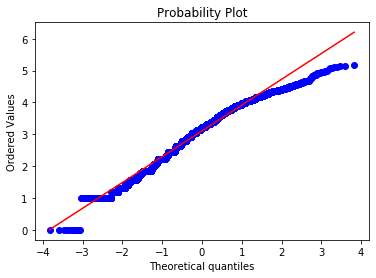

In [41]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# корнем четвертой степени для переменной FACT_LIVING_TERM, 
# используем модуль, чтобы не вычислять корни 
# отрицательных чисел, и затем учитываем знак числа
sns.distplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/4)), fit=norm)
fig = plt.figure()
res = stats.probplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/4)), plot=plt)
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/4))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос -0.222969034559257
Эксцесс -0.6070016622741847


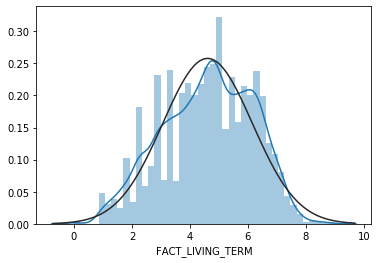

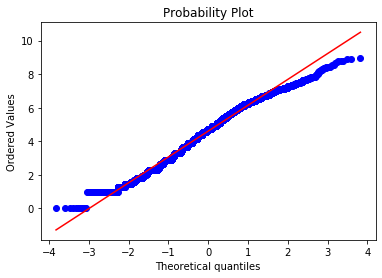

In [42]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# кубическим корнем для переменной FACT_LIVING_TERM,
# используем модуль, чтобы не вычислять корни
# отрицательных чисел, и затем учитываем знак числа
sns.distplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/3)), fit=norm)
fig = plt.figure()
res = stats.probplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/3)), plot=plt)
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/3))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

Скос 0.13476855245733127
Эксцесс -0.7037178210399051


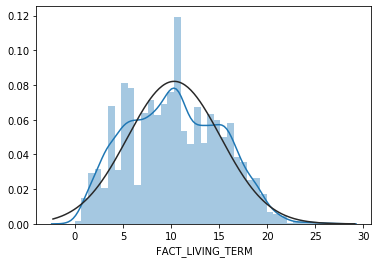

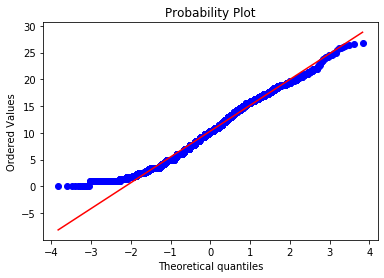

In [43]:
# строим гистограмму распределения и график
# квантиль-квантиль, применив преобразование 
# квадратным корнем для переменной FACT_LIVING_TERM,
# используем модуль, чтобы не вычислять корни
# отрицательных чисел, и затем учитываем знак числа
sns.distplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/2)), fit=norm)
fig = plt.figure()
res = stats.probplot(np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/2)), plot=plt)
var = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/2))
print("Скос", var.skew())
print("Эксцесс", var.kurtosis())

In [44]:
# импортируем функцию boxcox
from scipy.stats import boxcox
# выполняем преобразование Бокса-Кокса
box_transformed, lam = boxcox(train['FACT_LIVING_TERM'] + a)
print("Lambda: %f" % lam)

Lambda: 0.374517


Скос -0.12680041237747264
Эксцесс -0.6780113070988993


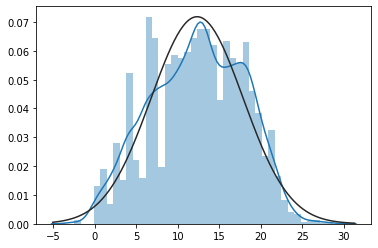

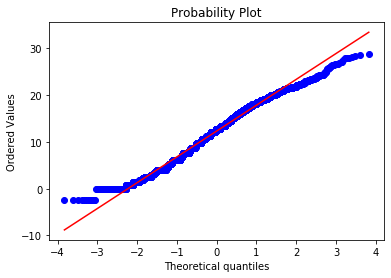

In [45]:
# строим гистограмму распределения и график
# квантиль-квантиль для переменной monthly_income,
# преобразованной с помощью Бокса-Кокса
sns.distplot(box_transformed, fit=norm)
fig = plt.figure()
res = stats.probplot(box_transformed, plot=plt)
box_transformed = pd.Series(box_transformed)
print("Скос", box_transformed.skew())
print("Эксцесс", box_transformed.kurtosis())

In [46]:
#наиболее хорошие результаты у кубического корня и Бокса-Кокса

## I.9. Биннинг как один из способов конструирования новых признаков, использующий результаты математических вычислений (нужно выполнять только после разбиения на обучение/контроль)

In [47]:
# на основе переменной PERSONAL_INCOME создаем временную переменную 
# PERSONAL_INCOME_CAT, у которой метки категорий будут 
# повторять метки категорий FAMILY_INCOME
bins = [-np.inf, 5000, 10000, 20000, 50000, np.inf]
lab = ['до 5000 руб.', 'от 5000 до 10000 руб.', 'от 10000 до 20000 руб.', 
       'от 20000 до 50000 руб.', 'свыше 50000 руб.']
train['PERSONAL_INCOME_CAT'] = pd.cut(train['PERSONAL_INCOME'], bins, labels=lab)
test['PERSONAL_INCOME_CAT'] = pd.cut(test['PERSONAL_INCOME'], bins, labels=lab)

In [48]:
# выводим метки переменной PERSONAL_INCOME_CAT
train['PERSONAL_INCOME_CAT'].unique()

[от 10000 до 20000 руб., от 5000 до 10000 руб., до 5000 руб., от 20000 до 50000 руб., свыше 50000 руб.]
Categories (5, object): [до 5000 руб. < от 5000 до 10000 руб. < от 10000 до 20000 руб. < от 20000 до 50000 руб. < свыше 50000 руб.]

In [49]:
# создаем переменную PERSONAL_FAMILY_INCOME, которая принимает значение 1, если 
# категория переменной PERSONAL_INCOME_CAT совпадает с категорией 
# переменной FAMILY_INCOME, или 0 в противном случае, затем
# преобразовываем в тип object
train['PERSONAL_FAMILY_INCOME'] = np.where(train['PERSONAL_INCOME_CAT'] == train['FAMILY_INCOME'], 
                                           1, 0).astype('object')
test['PERSONAL_FAMILY_INCOME'] = np.where(test['PERSONAL_INCOME_CAT'] == test['FAMILY_INCOME'], 
                                          1, 0).astype('object')

# удаляем переменную PERSONAL_INCOME_CAT
train.drop('PERSONAL_INCOME_CAT', axis=1, inplace=True)
test.drop('PERSONAL_INCOME_CAT', axis=1, inplace=True)

In [50]:
# задаем точки, в которых будут находится границы категорий 
# будущей переменной CREDITCAT
bins = [-np.inf, 7292, 9427, 14169, 27449, np.inf]
# осуществляем биннинг переменной CREDIT и записываем
# результаты в новую переменную CREDITCAT
train['CREDITCAT'] = pd.cut(train['CREDIT'], bins).astype('object')
test['CREDITCAT'] = pd.cut(test['CREDIT'], bins).astype('object')

In [51]:
# задаем точки, в которых будут находится границы категорий 
# будущей переменной FSTPAYMENTCAT
bins = [-np.inf, 1500, 4995, np.inf]
# осуществляем биннинг переменной FST_PAYMENT и записываем
# результаты в новую переменную FSTPAYMENTCAT
train['FSTPAYMENTCAT'] = pd.cut(train['FST_PAYMENT'], bins).astype('object')
test['FSTPAYMENTCAT'] = pd.cut(test['FST_PAYMENT'], bins).astype('object')

In [52]:
# пишем функцию, которая создает 
# из списка списков словарь
def list_to_dict(input_list):    
    output_dict = {}    
    for n, sample_list in enumerate(input_list):
        for value in sample_list:
            output_dict[value] = n                
    return output_dict

# создаем список списков для
# переменной GEN_TITLE
map_data_list = [
    ['Рабочий',
     'Служащий',
     'Работник сферы услуг',
     'Другое',
     'Индивидуальный предприниматель',
     'Руководитель низшего звена'],
    ['Специалист',
     'Руководитель среднего звена'],
    ['Не указано'],
    ['Высококвалифиц. специалист', 'Руководитель высшего звена']
]

# создаем из списка списков словарь
map_data_dict = list_to_dict(map_data_list)

# укрупняем категории переменной GEN_TITLE
train['GEN_TITLE'] = train['GEN_TITLE'].map(map_data_dict).astype('object')
test['GEN_TITLE'] = test['GEN_TITLE'].map(map_data_dict).astype('object')

# смотрим результат укрупнения на обучающей выборке
train['GEN_TITLE'].value_counts(dropna=False)

1    5119
0    3450
2    1428
3     659
Name: GEN_TITLE, dtype: int64

In [53]:
# создаем список списков для
# переменной REGION_NM
map_data_list2 = [
    ['ЮЖНЫЙ', 'ЦЕНТРАЛЬНЫЙ 1', 'ЦЕНТРАЛЬНЫЙ 2'],
    ['ЗАПАДНО-СИБИРСКИЙ', 'ВОСТОЧНО-СИБИРСКИЙ', 'УРАЛЬСКИЙ',
     'ДАЛЬНЕВОСТОЧНЫЙ', 'СЕВЕРО-ЗАПАДНЫЙ', 'ЦЕНТРАЛЬНЫЙ ОФИС'],
    ['ПРИВОЛЖСКИЙ']
]

# создаем из списка списков словарь
map_data_dict2 = list_to_dict(map_data_list2)

# на основе укрупнения категорий переменной REGION_NM 
# создадим переменную REGIONCAT
train['REGIONCAT'] = train['REGION_NM'].map(map_data_dict2).astype('object')
test['REGIONCAT'] = test['REGION_NM'].map(map_data_dict2).astype('object')

# смотрим новую переменную в обучающей выборке
train['REGIONCAT'].value_counts(dropna=False)

1    4699
0    4048
2    1909
Name: REGIONCAT, dtype: int64

## I.10. Выполнение преобразований, исходя из информации гистограмм распределения и графиков квантиль-квантиль

In [54]:
# выполняем логарифмическое преобразование
# переменной PERSONAL_INCOME
train['PERSONAL_INCOME'] = np.log(train['PERSONAL_INCOME'] + a)
test['PERSONAL_INCOME'] = np.log(test['PERSONAL_INCOME'] + a)

# выполняем логарифмическое преобразование
# переменной CREDIT
train['CREDIT'] = np.log(train['CREDIT'] + a)
test['CREDIT'] = np.log(test['CREDIT'] + a)

# выполняем логарифмическое преобразование
# переменной WORK_TIME
train['WORK_TIME'] = np.log(train['WORK_TIME'] + a)
test['WORK_TIME'] = np.log(test['WORK_TIME'] + a)

# выполняем преобразование переменной FACT_LIVING_TERM
# кубическим корнем
train['FACT_LIVING_TERM'] = np.sign(train['FACT_LIVING_TERM']) * (
    train['FACT_LIVING_TERM'].abs() ** (1/3))
test['FACT_LIVING_TERM'] = np.sign(test['FACT_LIVING_TERM']) * (
    test['FACT_LIVING_TERM'].abs() ** (1/3))

# выполняем логарифмическое преобразование
# переменной LOAN_AVG_DLQ_AMT
train['LOAN_AVG_DLQ_AMT'] = np.log(train['LOAN_AVG_DLQ_AMT'] + a)
test['LOAN_AVG_DLQ_AMT'] = np.log(test['LOAN_AVG_DLQ_AMT'] + a)

## I.11. Конструирование новых признаков

In [55]:
# создаем переменную CHILD_DEP – отношение количества детей (CHILD_TOTAL)
# к общему количеству детей и иждивенцев (CHILD_TOTAL и DEPENDANTS)
train['CHILD_DEP'] = train['CHILD_TOTAL'] / (train['CHILD_TOTAL'] + train['DEPENDANTS'])
test['CHILD_DEP'] = test['CHILD_TOTAL'] / (test['CHILD_TOTAL'] + test['DEPENDANTS'])


# если переменная содержит пропуск, то возвращается значение 0,
# если пропуска нет, то возвращается исходное значение переменной
train['CHILD_DEP'] = np.where(train['CHILD_DEP'].isnull(), 0, train['CHILD_DEP'])
test['CHILD_DEP'] = np.where(test['CHILD_DEP'].isnull(), 0, test['CHILD_DEP'])

# если бы наша переменная содержала бесконечные значения, то можно было бы воспользоваться
# train['CHILD_DEP'] = np.where(np.isfinite(train['CHILD_DEP']), train['CHILD_DEP'], 0)
# т. е. если переменная CHILD_DEP содержит конечное значение, возвращаем исходное значение;
# если она содержит бесконечное значение, возвращаем значение 0
# создаем переменную PAYMENT – сумму ежемесячного взноса
# по кредиту, разделив сумму кредита (CREDIT) на срок кредита (TERM)
train['PAYMENT'] = np.log((train['CREDIT'] / train['TERM']) + a)
test['PAYMENT'] = np.log((test['CREDIT'] / test['TERM']) + a)

# создаем переменную PTI – коэффициент долговой нагрузки, разделив сумму ежемесячного взноса
# по кредиту (PAYMENT) на личный доход (PERSONAL_INCOME)
train['PTI'] = train['PAYMENT'] / train['PERSONAL_INCOME']
test['PTI'] = test['PAYMENT'] / test['PERSONAL_INCOME']

#создаем переменную SHARE_INCOME - долю дохода от суммы кредита
train['SHARE_INCOME'] = train['PERSONAL_INCOME'] / train['CREDIT']
test['SHARE_INCOME'] = test['PERSONAL_INCOME'] / test['CREDIT']

# вычитаем количество погашенных ссуд (LOAN_NUM_CLOSED)
# из общего количество ссуд (LOAN_NUM_TOTAL)
train['LOAN_NUM_OPEN'] = train['LOAN_NUM_TOTAL'] - train['LOAN_NUM_CLOSED']
test['LOAN_NUM_OPEN'] = test['LOAN_NUM_TOTAL'] - test['LOAN_NUM_CLOSED']

# создаем переменную PAYM_TO_LOAN – отношение количества
# платежей (LOAN_NUM_PAYM) к общему количеству ссуд (LOAN_NUM_TOTAL)
train['PAYM_TO_LOAN'] = train['LOAN_NUM_PAYM'] / train['LOAN_NUM_TOTAL']
test['PAYM_TO_LOAN'] = test['LOAN_NUM_PAYM'] / test['LOAN_NUM_TOTAL']


# создаем переменную DLQ_TO_PAYM – отношение количества просрочек
# (LOAN_DLQ_NUM) к общему количеству платежей (LOAN_NUM_PAYM)
train['DLQ_TO_PAYM'] = train['LOAN_DLQ_NUM'] / train['LOAN_NUM_PAYM']
test['DLQ_TO_PAYM'] = test['LOAN_DLQ_NUM'] / test['LOAN_NUM_PAYM']

# создаем переменную FST_SHARE – отношение суммы первого платежа по кредиту
# к объединенной сумме первого платежа (FST_PAYMENT) и кредита (CREDIT)
train['FST_SHARE'] = train['FST_PAYMENT'] / (train['FST_PAYMENT'] + train['CREDIT'])
test['FST_SHARE'] = test['FST_PAYMENT'] / (test['FST_PAYMENT'] + test['CREDIT'])

# создаем переменную CLOSED_TO_TOTAL – коэффициент погашения ссуд, разделив количество
# погашенных ссуд (LOAN_NUM_CLOSED) на общее количество ссуд (LOAN_NUM_TOTAL)
train['CLOSED_TO_TOTAL'] = train['LOAN_NUM_CLOSED'] / train['LOAN_NUM_TOTAL']
test['CLOSED_TO_TOTAL'] = test['LOAN_NUM_CLOSED'] / test['LOAN_NUM_TOTAL']



# создаем DLQ_TIME – индекс времени наступления максимальной просрочки,
# разделив номер максимальной просрочки (LOAN_MAX_DLQ)
# на количество просрочек (LOAN_DLQ_NUM)
train['DLQ_TIME'] = train['LOAN_MAX_DLQ'] / train['LOAN_DLQ_NUM']
test['DLQ_TIME'] = test['LOAN_MAX_DLQ'] / test['LOAN_DLQ_NUM']

# если переменная содержит пропуск, то возвращается значение 0,
# если пропуска нет, то возвращается исходное значение переменной
train['DLQ_TIME'] = np.where(train['DLQ_TIME'].isnull(), 0, train['DLQ_TIME'])
test['DLQ_TIME'] = np.where(test['DLQ_TIME'].isnull(), 0, test['DLQ_TIME'])

# создаем переменную LOAN_MAX_DLQ_RANGE – разницу между максимальной суммой
# просрочки (LOAN_MAX_DLQ_AMT) и средней суммой просрочки (LOAN_AVG_DLQ_AMT)
train['LOAN_MAX_DLQ_RANGE'] = ((train['LOAN_MAX_DLQ_AMT'] - train['LOAN_AVG_DLQ_AMT']) /
train['LOAN_AVG_DLQ_AMT']).abs()
test['LOAN_MAX_DLQ_RANGE'] = ((test['LOAN_MAX_DLQ_AMT'] - test['LOAN_AVG_DLQ_AMT']) /
test['LOAN_AVG_DLQ_AMT']).abs()

# если переменная содержит пропуск, то возвращается значение 0;
# если пропуска нет, то возвращается исходное значение переменной
train['LOAN_MAX_DLQ_RANGE'] = np.where(train['LOAN_MAX_DLQ_RANGE'].isnull(), 0,
train['LOAN_MAX_DLQ_RANGE'])
test['LOAN_MAX_DLQ_RANGE'] = np.where(test['LOAN_MAX_DLQ_RANGE'].isnull(), 0,
test['LOAN_MAX_DLQ_RANGE'])

## I.12. Стандартизация

In [56]:
# выполняем стандартизацию количественных переменных  
num_cols = [c for c in train.columns if train[c].dtype.name != 'object']
train_copy = train.copy()
for column in train.select_dtypes(exclude='object').columns:    
    train[column] = (train[column] - train[column].mean()) / train[column].std()
    test[column] = (test[column] - train_copy[column].mean()) / train_copy[column].std()

In [57]:
# выводим информацию об общем количестве пропущенных 
# наблюдений в обучающей и контрольной выборках
print(train.isnull().sum().sum())
print(test.isnull().sum().sum())

0
0


## I.13. Дамми-кодирование

In [58]:
# выполняем дамми-кодирование
X_train = pd.get_dummies(train)
X_test = pd.get_dummies(test)
print(X_train.shape)
print(X_test.shape)

(10656, 437)
(4567, 437)


## I.15. Построение логистической регрессии с помощью класса LogisticRegression библиотеки scikit-learn

In [59]:
# строим логистическую регрессию
logreg = LogisticRegression(solver='liblinear').fit(X_train, y_train)
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.746
AUC на контрольной выборке: 0.687


In [60]:
# строим логистическую регрессию,
# используем l1-регуляризацию (лассо), которая
# устанавливают некоторые оценки коэффициентов 
# регрессии точно в нуле и тем самым осуществляет 
# отбор переменных
logreg = LogisticRegression(C=0.12, solver='liblinear', penalty='l1').fit(X_train, y_train)
print("AUC на обучающей выборке: {:.3f}".
      format(roc_auc_score(y_train, logreg.predict_proba(X_train)[:, 1])))
print("AUC на контрольной выборке: {:.3f}".
      format(roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])))

AUC на обучающей выборке: 0.723
AUC на контрольной выборке: 0.694


## I.16. Настройка гиперпараметров логистической регрессии с помощью класса GridSearchCV

In [61]:
# создаем экземпляр класса StratifiedKFold, 10-блочную
# перекрестную проверку со случайным перемешиванием данных
strat = StratifiedKFold(n_splits=10, shuffle=True, 
                        random_state=42)
# создаем экземпляр класса LogisticRegression,
# логистическую регрессию с L1-регуляризацией
logreg_grid = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
# задаем сетку гиперпараметров, будем перебирать 
# разные значения штрафа
param_grid = {'C': [0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32]}

In [62]:
# создаем экземпляр класса GridSearchCV
grid_search = GridSearchCV(logreg_grid, param_grid, 
                           scoring='roc_auc', 
                           return_train_score=True,
                           n_jobs=1, cv=strat)
# запускаем решетчатый поиск
grid_search.fit(X_train, y_train)
# проверяем модель со значением гиперпараметра, дающим наибольшее
# значение AUC (усредненное по контрольным блокам перекрестной
# проверки), на тестовой выборке
test_score = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
# смотрим результаты решетчатого поиска
print("AUC на тестовой выборке: {:.3f}".format(test_score))
print("Наилучшее значение гиперпараметра C: {}".format(grid_search.best_params_))
print("Наилучшее значение AUC: {:.3f}".format(grid_search.best_score_))

AUC на тестовой выборке: 0.694
Наилучшее значение гиперпараметра C: {'C': 0.18}
Наилучшее значение AUC: 0.701


In [63]:
# преобразуем результаты поиска в датафрейм
# и выведем их
results = pd.DataFrame(grid_search.cv_results_)
table = results.pivot_table(values=['mean_test_score'], 
                            index=['param_C'])
print(table)

         mean_test_score
param_C                 
0.180              0.701
0.200              0.701
0.220              0.701
0.240              0.700
0.260              0.700
0.280              0.699
0.300              0.699
0.320              0.699


## ЭТАП II. ПОСТРОЕНИЕ МОДЕЛИ НА ВСЕЙ ИСТОРИЧЕСКОЙ ВЫБОРКЕ И ПРИМЕНЕНИЕ К НОВЫМ ДАННЫМ

## II.1. Считывание CSV-файла, содержащего исторические данные, в объект DataFrame

In [64]:
# загружаем набор данных
fulldata = pd.read_csv('Credit_OTP.csv', encoding='cp1251', sep=';')

## II.2. Предварительная обработка исторических данных

In [65]:
# пишем функцию, выполняющую предварительную обработку
# исторических данных
def preprocessing(df):
    # удаляем идентификационную переменную AGREEMENT_RK,
    # потому что у нее количество уникальных значений
    # равно количеству наблюдений, переменную DL_DOCUMENT_FL, 
    # потому что у нее одно уникальное значение
    df.drop(['AGREEMENT_RK', 'DL_DOCUMENT_FL'], axis=1, inplace=True)
        
    # переменные, неверно записанные как количественные,
    # преобразуем в тип object
    object_columns = df.columns[df.columns.str.contains('FL|GENDER')]
    df[object_columns] = df[object_columns].astype('object')
    
    # в указанных переменных заменяем запятую на точку в качестве
    # десятичного разделителя и преобразуем в тип float    
    for column in ['PERSONAL_INCOME', 'CREDIT', 'FST_PAYMENT', 
               'LOAN_AVG_DLQ_AMT', 'LOAN_MAX_DLQ_AMT']:
        df[column] = df[column].str.replace(',', '.').astype('float')
    
    
    # если в интересующей нас переменной есть пропуск 
    # или при этом переменная SOCSTATUS_PENS_FL имеет значение 1,
    # заменяем такие пропуски меткой "Не указано"
    df['GEN_INDUSTRY'] = np.where(df['GEN_INDUSTRY'].isnull()
                                  | (df['SOCSTATUS_PENS_FL'] == 1), 
                                  'Не указано', df['GEN_INDUSTRY'])
    df['GEN_TITLE'] = np.where(df['GEN_TITLE'].isnull()
                               | (df['SOCSTATUS_PENS_FL'] == 1), 
                               'Не указано', df['GEN_TITLE'])
    df['ORG_TP_STATE'] = np.where(df['ORG_TP_STATE'].isnull()
                                  | (df['SOCSTATUS_PENS_FL'] == 1),
                                  'Не указано', df['ORG_TP_STATE'])
    df['ORG_TP_FCAPITAL'] = np.where(df['ORG_TP_FCAPITAL'].isnull()
                                     | (df['SOCSTATUS_PENS_FL'] == 1), 
                                     'Не указано', df['ORG_TP_FCAPITAL'])

    # заменяем пропуски в указанных переменных
    # меткой "Не указано"
    df['JOB_DIR'] = np.where(df['JOB_DIR'].isnull(), 'Не указано', df['JOB_DIR'])    
    df['REGION_NM'] = np.where(df['REGION_NM'].isnull(), 'Не указано', df['REGION_NM'])
    
    # пропуски в переменной TP_PROVINCE заменим значением
    # переменной FACT_ADDRESS_PROVINCE
    df['TP_PROVINCE'] = np.where(df['TP_PROVINCE'].isnull(), 
                                 df['FACT_ADDRESS_PROVINCE'], df['TP_PROVINCE'])
    
    # заменяем пропуски в переменной 
    # PREVIOUS_CARD_NUM_UTILIZED нулями
    df['PREVIOUS_CARD_NUM_UTILIZED'] = np.where(df['PREVIOUS_CARD_NUM_UTILIZED'].isnull(), 0, 
                                                df['PREVIOUS_CARD_NUM_UTILIZED'])
    
    # заменяем категорию "Не указано" на категорию "ЮЖНЫЙ"
    df['REGION_NM'] = np.where(df['REGION_NM'] == 'Не указано', 'ЮЖНЫЙ', df['REGION_NM'])
    
    # заменяем неверную категорию "ПОВОЛЖСКИЙ" на категорию "ПРИВОЛЖСКИЙ"
    df.at[df['REGION_NM'] == 'ПОВОЛЖСКИЙ', 'REGION_NM'] = 'ПРИВОЛЖСКИЙ'
    
    data.at[data['POSTAL_ADDRESS_PROVINCE'] == 'Москва', 'POSTAL_ADDRESS_PROVINCE'] = 'Московская область'
    
    # записываем редкие категории в одну отдельную категорию
    for i in ['REG_ADDRESS_PROVINCE', 'POSTAL_ADDRESS_PROVINCE', 'FACT_ADDRESS_PROVINCE']:
        df[i] = np.where(#(df[i] == 'Москва')
                          (df[i] == 'Хакасия')
                         | (df[i] == 'Ямало-Ненецкий АО')
                         | (df[i] == 'Магаданская область')
                         | (df[i] == 'Калмыкия')
                         | (df[i] == 'Дагестан')
                         | (df[i] == 'Агинский Бурятский АО')
                         | (df[i] == 'Усть-Ордынский Бурятский АО')
                         | (df[i] == 'Эвенкийский АО')
                         | (df[i] == 'Коми-Пермяцкий АО')
                         | (df[i] == 'Чечня'), 
                         'ДРУГОЕ', df[i])


    df['TP_PROVINCE'] = np.where((df['TP_PROVINCE'] == 'Сахалинская область')
                                 | (df['TP_PROVINCE'] == 'Еврейская АО')
                                 | (df['TP_PROVINCE'] == 'Магаданская область')
                                 | (df['TP_PROVINCE'] == 'Дагестан')
                                 | (df['TP_PROVINCE'] == 'Кабардино-Балкария'), 
                                 'ДРУГОЕ', df['TP_PROVINCE'])
    
    # укрупняем категории переменной EDUCATION
    df.loc[df['EDUCATION'] == 'Ученая степень', 'EDUCATION'] = 'Высшее'
    df.loc[df['EDUCATION'] == 'Два и более высших образования', 
           'EDUCATION'] = 'Высшее'

    # записываем некоторые категории переменной GEN_INDUSTRY 
    # в отдельную категорию
    df.loc[df['GEN_INDUSTRY'] == 'Юридические услуги/нотариальные услуги', 
           'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Страхование', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Туризм', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Недвижимость', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Управляющая компания', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Логистика', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Подбор персонала', 'GEN_INDUSTRY'] = 'Другие сферы'
    df.loc[df['GEN_INDUSTRY'] == 'Маркетинг', 'GEN_INDUSTRY'] = 'Другие сферы'
    
    # укрупняем категории переменной GEN_TITLE
    df.loc[df['GEN_TITLE'] == 'Партнер', 'GEN_TITLE'] = 'Другое'
    df.loc[df['GEN_TITLE'] == 'Военнослужащий по контракту', 'GEN_TITLE'] = 'Другое'
    
    # укрупняем категории переменной ORG_TP_STATE
    df.loc[df['ORG_TP_STATE'] == 'Частная ком. с инос. капиталом', 
           'ORG_TP_STATE'] = 'Частная компания'
    
    # укрупняем категории переменной JOB_DIR
    df.loc[df['JOB_DIR'] == 'Реклама и маркетинг', 'JOB_DIR'] = 'Другое'
    df.loc[df['JOB_DIR'] == 'Кадровая служба и секретариат', 'JOB_DIR'] = 'Другое'
    df.loc[df['JOB_DIR'] == 'Пр-техн. обесп. и телеком.', 'JOB_DIR'] = 'Другое'
    df.loc[df['JOB_DIR'] == 'Юридическая служба', 'JOB_DIR'] = 'Другое'
    
    # создаем переменную FACT_TP_FL, которая принимает значение 1, если 
    # область фактического пребывания клиента и область торговой точки, 
    # где клиент брал последний кредит, совпадают, или 0
    # в противном случае
    df['FACT_TP_FL'] = np.where(df['FACT_ADDRESS_PROVINCE'] == df['TP_PROVINCE'], 
                                1, 0).astype('object')
           
    # значения переменной FACT_LIVING_TERM берем по модулю, чтоб 
    # избавиться от отрицательных значений
    df['FACT_LIVING_TERM'] = df['FACT_LIVING_TERM'].abs()
    
    # наблюдения, в которых количество лет проживания 
    # по месту фактического пребывания, превышает
    # возраст, записываем как пропуски 
    df['FACT_LIVING_TERM'] = np.where(df['FACT_LIVING_TERM'] / 12 > df['AGE'], 
                                      np.NaN, df['FACT_LIVING_TERM'])
    
    # импутируем пропуски медианой
    df['FACT_LIVING_TERM'].fillna(df['FACT_LIVING_TERM'].median(), inplace=True)
    
    # наблюдения, в которых время работы в годах превышает 
    # возраст (например, человек работает 40 лет, а живет 
    # всего 25), записываем как пропуски 
    df['WORK_TIME'] = np.where(df['WORK_TIME'] / 12 > df['AGE'], 
                               np.NaN, df['WORK_TIME'])
    
    # наблюдения, в которых разница между возрастом и временем работы в годах 
    # меньше 16 (например, у 30-летнего время работы в годах составляет 20 лет,
    # получается, он работает с 10 лет), записываем как пропуски 
    df['WORK_TIME'] = np.where((df['AGE'] - df['WORK_TIME'] / 12) < 16, 
                               np.NaN, df['WORK_TIME'])
    
    # импутируем пропуски в переменной WORK_TIME медианой
    df['WORK_TIME'].fillna(df['WORK_TIME'].median(), inplace=True)
    
    # на основе переменной PERSONAL_INCOME создаем переменную 
    # PERSONAL_INCOME_CAT, у которой метки категорий будут 
    # повторять метки категорий FAMILY_INCOME
    bins = [-np.inf, 5000, 10000, 20000, 50000, np.inf]
    lab = ['до 5000 руб.', 'от 5000 до 10000 руб.', 'от 10000 до 20000 руб.', 
           'от 20000 до 50000 руб.', 'свыше 50000 руб.']
    df['PERSONAL_INCOME_CAT'] = pd.cut(df['PERSONAL_INCOME'], bins, labels=lab) 
    
    # создаем переменную PERSONAL_FAMILY_INCOME, которая принимает значение 1, если 
    # категория переменной PERSONAL_INCOME_CAT совпадает с категорией 
    # переменной FAMILY_INCOME, или 0 в противном случае, затем
    # преобразовываем в тип object
    df['PERSONAL_FAMILY_INCOME'] = np.where(df['PERSONAL_INCOME_CAT'] == df['FAMILY_INCOME'], 
                                            1, 0).astype('object')
    
    # удаляем переменную PERSONAL_INCOME_CAT
    df.drop('PERSONAL_INCOME_CAT', axis=1, inplace=True)
    
    # задаем точки, в которых будут находится границы категорий 
    # будущей переменной CREDITCAT
    bins = [-np.inf, 7292, 9427, 14169, 27449, np.inf]
    
    # осуществляем биннинг переменной CREDIT и записываем
    # результаты в новую переменную CREDITCAT
    df['CREDITCAT'] = pd.cut(df['CREDIT'], bins).astype('object')
    
    # задаем точки, в которых будут находится границы категорий 
    # будущей переменной FSTPAYMENTCAT
    bins = [-np.inf, 1500, 4995, np.inf]
    
    # осуществляем биннинг переменной FST_PAYMENT и записываем
    # результаты в новую переменную FSTPAYMENTCAT
    df['FSTPAYMENTCAT'] = pd.cut(df['FST_PAYMENT'], bins).astype('object')
    
    # пишем функцию, которая создает 
    # из списка списков словарь
    def list_to_dict(input_list):    
        output_dict = {}    
        for n, sample_list in enumerate(input_list):
            for value in sample_list:
                output_dict[value] = n                
        return output_dict
    
    # создаем список списков для
    # переменной GEN_TITLE
    map_df_list = [
        ['Рабочий',
         'Служащий',
         'Работник сферы услуг',
         'Другое',
         'Индивидуальный предприниматель',
         'Руководитель низшего звена'],
        ['Специалист',
         'Руководитель среднего звена'],
        ['Не указано'],
        ['Высококвалифиц. специалист', 
         'Руководитель высшего звена']
    ]
    
    # создаем из списка списков словарь
    map_df_dict = list_to_dict(map_df_list)
    
    # укрупняем категории переменной GEN_TITLE
    df['GEN_TITLE'] = df['GEN_TITLE'].map(map_df_dict).astype('object')
    
    # создаем список списков для
    # переменной REGION_NM
    map_df_list2 = [
        ['ЮЖНЫЙ', 'ЦЕНТРАЛЬНЫЙ 1', 'ЦЕНТРАЛЬНЫЙ 2'],
        ['ЗАПАДНО-СИБИРСКИЙ', 'ВОСТОЧНО-СИБИРСКИЙ', 'УРАЛЬСКИЙ',
         'ДАЛЬНЕВОСТОЧНЫЙ', 'СЕВЕРО-ЗАПАДНЫЙ', 'ЦЕНТРАЛЬНЫЙ ОФИС'],
        ['ПРИВОЛЖСКИЙ']
    ]
    
    # создаем из списка списков словарь
    map_df_dict2 = list_to_dict(map_df_list2)
    
    # на основе укрупнения категорий переменной REGION_NM 
    # создадим переменную REGIONCAT
    df['REGIONCAT'] = df['REGION_NM'].map(map_df_dict2).astype('object')
    
    # задаем константу
    a = 0.01
    # выполняем логарифмическое преобразование
    # переменной PERSONAL_INCOME
    df['PERSONAL_INCOME'] = np.log(df['PERSONAL_INCOME'].clip(0) + a)
    
    # выполняем логарифмическое преобразование
    # переменной CREDIT
    df['CREDIT'] = np.log(df['CREDIT'].clip(0) + a)
    
    # выполняем логарифмическое преобразование
    # переменной WORK_TIME
    df['WORK_TIME'] = np.log(df['WORK_TIME'].clip(0) + a)
    
    # выполняем преобразование переменной FACT_LIVING_TERM
    # кубическим корнем
    df['FACT_LIVING_TERM'] = np.sign(df['FACT_LIVING_TERM']) * (
        df['FACT_LIVING_TERM'].abs() ** (1/3))
    
    # выполняем логарифмическое преобразование 
    # переменной LOAN_AVG_DLQ_AMT
    df['LOAN_AVG_DLQ_AMT'] = np.log(df['LOAN_AVG_DLQ_AMT'].clip(0) + a)
    
    # создаем переменную PAYMENT - сумму ежемесячного взноса
    # по кредиту, разделив сумму кредита (CREDIT)
    # на срок кредита (TERM)
    df['PAYMENT'] = np.log((df['CREDIT'].clip(0) / df['TERM'].clip(0)) + a)
    
    # создаем переменную PTI - коэффициент долговой нагрузки, 
    # разделив сумму ежемесячного взноса по кредиту (PAYMENT)
    # на личный доход (PERSONAL_INCOME)
    df['PTI'] = df['PAYMENT'] / df['PERSONAL_INCOME']
    
    #создаем переменную SHARE_INCOME - долю дохода от суммы кредита
    df['SHARE_INCOME'] = df['PERSONAL_INCOME'] / df['CREDIT']
    
    # вычитаем количество погашенных ссуд (LOAN_NUM_CLOSED)
    # из общего количество ссуд (LOAN_NUM_TOTAL)
    df['LOAN_NUM_OPEN'] = df['LOAN_NUM_TOTAL'] - df['LOAN_NUM_CLOSED']
    
    # создаем переменную PAYM_TO_LOAN – отношение количества платежей 
    # (LOAN_NUM_PAYM) к общему количеству ссуд (LOAN_NUM_TOTAL)
    df['PAYM_TO_LOAN'] = df['LOAN_NUM_PAYM'] / df['LOAN_NUM_TOTAL']
    
    # создаем переменную DLQ_TO_PAYM – отношение количества просрочек 
    # (LOAN_DLQ_NUM) к общему количеству платежей (LOAN_NUM_PAYM)
    df['DLQ_TO_PAYM'] = df['LOAN_DLQ_NUM'] / df['LOAN_NUM_PAYM']
    
    # создаем переменную FST_SHARE - отношение суммы первого платежа по кредиту
    # к объединенной сумме первого платежа (FST_PAYMENT) и кредита (CREDIT) 
    df['FST_SHARE'] = df['FST_PAYMENT'] / (df['FST_PAYMENT'] + df['CREDIT'])
    
    
    # создаем переменную CLOSED_TO_TOTAL - коэффициент погашения ссуд, 
    # разделив количество погашенных ссуд (LOAN_NUM_CLOSED)
    # на общее количество ссуд (LOAN_NUM_TOTAL)
    df['CLOSED_TO_TOTAL'] = df['LOAN_NUM_CLOSED'] / df['LOAN_NUM_TOTAL']
    
    # создаем переменную PAYM_TO_LOAN – отношение количества платежей 
    # (LOAN_NUM_PAYM) к общему количеству ссуд (LOAN_NUM_TOTAL)
    df['PAYM_TO_LOAN'] = df['LOAN_NUM_PAYM'] / df['LOAN_NUM_TOTAL']
    
    # создаем переменную DLQ_TO_PAYM – отношение количества просрочек 
    # (LOAN_DLQ_NUM) к общему количеству платежей (LOAN_NUM_PAYM)
    df['DLQ_TO_PAYM'] = df['LOAN_DLQ_NUM'] / df['LOAN_NUM_PAYM']
    
    # создаем переменную FST_SHARE - отношение суммы первого платежа по кредиту
    # к объединенной сумме первого платежа (FST_PAYMENT) и кредита (CREDIT) 
    df['FST_SHARE'] = df['FST_PAYMENT'] / (df['FST_PAYMENT'] + df['CREDIT'])

In [66]:
# выполняем предварительную обработку
# исторических данных
y = fulldata.pop('TARGET').values
preprocessing(fulldata)

In [67]:
fulldata_copy = fulldata.copy()
# выполняем стандартизацию количественных переменных
for column in fulldata.select_dtypes(exclude='object').columns:    
    fulldata[column] = (fulldata[column] - fulldata[column].mean()) / fulldata[column].std()

In [68]:
# выполняем дамми-кодирование
X = pd.get_dummies(fulldata)

## II.3. Обучение модели логистической регрессии на всех исторических данных

In [69]:
# строим логистическую регрессию
logreg = LogisticRegression(C=0.18, solver='liblinear', penalty='l1').fit(X, y)
print("AUC на всей исторической выборке: {:.3f}".
      format(roc_auc_score(y, logreg.predict_proba(X)[:, 1])))

AUC на всей исторической выборке: 0.724
